In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
# Get all imports and models

import torch
import open_clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import Blip2Processor, Blip2ForConditionalGeneration

# OpenCLIP (ViT-G)
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
    #"ViT-B-32", pretrained=None
)

clip_model.load_state_dict(torch.load("model/finetuned_clip.pt", map_location="cuda"))
clip_model = clip_model.to("cuda").eval()

# Tokenizer
clip_tokenizer = open_clip.get_tokenizer("ViT-B-32")

# BLIP-2 (Flan-T5-xl or any multilingual LLM variant)
blip_processor = Blip2Processor.from_pretrained(
    "Salesforce/blip2-flan-t5-xl"
)
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl", dtype=torch.float16, device_map="auto"
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Sascha\Desktop\LegaSea Model\fossil_env_311\Lib\site-packages\accelerate\utils\modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens', 'language_model.decoder.embed_tokens']
  warnings.warn(


In [63]:
# Grad CAM Utility

class ViTAttentionGradCAM:
    def __init__(self, model):
        self.model = model.visual
        self.attentions = []
        self.gradients = []
        self.hooks = []
        
        def forward_hook(module, inp, out):
            self.attentions.append(out)
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients.append(grad_out[0])

        # Hook into last attention block
        last_block = self.model.transformer.resblocks[-1].attn.out_proj
        self.hooks.append(last_block.register_forward_hook(forward_hook))
        self.hooks.append(last_block.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()

        logits = clip_model(input_tensor, clip_tokenizer(["object"])).logits_per_image
        loss = logits[0, class_idx]
        loss.backward()

        attn = self.attentions[-1].detach().mean(dim=1)
        grad = self.gradients[-1].detach().mean(dim=1)

        cam = (attn * grad).clamp(min=0)
        cam = cam / cam.max()
        cam = cam.reshape(7, 7).cpu()

        return cam



In [64]:
class ViTAttentionGradCAM:
    """
    Grad-CAM for OpenCLIP ViT models.
    Hooks the last transformer block in the visual tower to extract
    attention and gradients, then computes a simple Grad-CAM heatmap.
    """
    def __init__(self, clip_model, device=None):
        self.device = device if device is not None else next(clip_model.parameters()).device
        self.model = clip_model.to(self.device)  # full CLIP model
        self.attentions = []
        self.gradients = []
        self.hooks = []

        # -----------------------------
        # Hook functions
        # -----------------------------
        def forward_hook(module, inp, out):
            self.attentions.append(out)

        def backward_hook(module, grad_in, grad_out):
            self.gradients.append(grad_out[0])

        # Hook the last transformer block of the visual tower
        last_block = self.model.visual.transformer.resblocks[-1]
        self.hooks.append(last_block.register_forward_hook(forward_hook))
        self.hooks.append(last_block.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=0):
        self.model.zero_grad()
        self.attentions.clear()
        self.gradients.clear()

        input_tensor = input_tensor.to(self.device)

        image_features = self.model.encode_image(input_tensor)

        # pick a scalar output to backprop
        if image_features.shape[1] > class_idx:
            loss = image_features[0, class_idx]
        else:
            loss = image_features.sum()
        loss.backward()

        if len(self.attentions) == 0 or len(self.gradients) == 0:
            raise RuntimeError("Hooks did not fire!")

        attn = self.attentions[-1]  # [batch, tokens, dim]
        grad = self.gradients[-1]   # same shape

        # remove CLS token
        attn = attn[:, 1:, :]
        grad = grad[:, 1:, :]

        # Grad-CAM
        cam = (attn * grad).mean(dim=-1).clamp(min=0)  # [batch, num_patches]

        num_patches = int(cam.shape[1] ** 0.5)
        cam = cam.reshape(num_patches, num_patches).cpu()

        return cam



In [65]:
# Agent Framework
class Agent:
    def __init__(self, name, fn):
        self.name = name
        self.fn = fn
    
    def send(self, message):
        print(f"🔹 {self.name} received message")
        return self.fn(message)

# Agent 1
def vision_agent(image):
    img_tensor = clip_preprocess(image).unsqueeze(0)
    img_tensor = img_tensor.to(next(clip_model.parameters()).device)
    with torch.no_grad():
        features = clip_model.encode_image(img_tensor)
    return {"vision_features": features, "image": image}

VisionAgent = Agent("VisionAgent", vision_agent)

# Agent 2
device = next(clip_model.parameters()).device
gradcam = ViTAttentionGradCAM(clip_model, device=device)
def explain_agent(message):
    image = message["image"]
    img_tensor = clip_preprocess(image).unsqueeze(0).to(device)
    cam = gradcam.generate(img_tensor, class_idx=0)
    message["gradcam"] = cam
    return message

ExplainAgent = Agent("ExplainabilityAgent", explain_agent)

# Agent 3
def reasoning_agent(message):
    image = message["image"]
    cam = message["gradcam"]

    # Create prompt including Grad-CAM explanation
    prompt = (
        "Explain what is in this image using Dutch and English. "
        "Use this attention map as reasoning signal."
    )

    inputs = blip_processor(image, prompt, return_tensors="pt").to("cuda")
    output = blip_model.generate(**inputs, max_new_tokens=120)

    message["explanation"] = blip_processor.decode(output[0], skip_special_tokens=True)
    return message

ReasoningAgent = Agent("ReasoningAgent", reasoning_agent)



In [66]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

class ViTGradCAMSafe:
    def __init__(self, clip_model, device=None):
        self.device = device if device else next(clip_model.parameters()).device
        self.model = clip_model.to(self.device)
        self.attentions = []
        self.gradients = []
        self.hooks = []

        def forward_hook(module, inp, out):
            self.attentions.append(out)

        def backward_hook(module, grad_in, grad_out):
            self.gradients.append(grad_out[0])

        # Hook the output projection of last visual transformer block
        last_block = self.model.visual.transformer.resblocks[-1].attn.out_proj
        self.hooks.append(last_block.register_forward_hook(forward_hook))
        self.hooks.append(last_block.register_backward_hook(backward_hook))

    def generate(self, img_tensor):
        self.model.zero_grad()
        self.attentions.clear()
        self.gradients.clear()

        img_tensor = img_tensor.to(self.device)
        features = self.model.encode_image(img_tensor)

        # Backprop from sum of features to get gradients
        features.sum().backward()

        if not self.attentions or not self.gradients:
            raise RuntimeError("Hooks did not fire!")

        attn = self.attentions[-1]    # [1, tokens, hidden]
        grad = self.gradients[-1]      # same shape

        # Remove CLS token
        attn = attn[:, 1:, :]
        grad = grad[:, 1:, :]

        # Element-wise multiply and mean over hidden dim
        cam = (attn * grad).mean(dim=-1)[0]  # [num_patches]

        # Reshape to patch grid
        num_patches = int(cam.shape[0] ** 0.5)
        cam = cam.reshape(num_patches, num_patches)
        cam = cam.cpu().detach().numpy()
        # Normalize and enhance contrast
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)
        cam = cam ** 0.3

        return cam

def show_gradcam(image, cam):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    img = np.array(image)

    # Make sure cam is numpy
    if isinstance(cam, torch.Tensor):
        cam = cam.cpu().detach().numpy()

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam_resized = np.clip(cam_resized, 0, 1)

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    overlay = 0.5*img + 0.5*heatmap
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    plt.show()


🔹 VisionAgent received message
🔹 ReasoningAgent received message
FINAL EXPLANATION:
dict_keys(['image', 'gradcam', 'explanation'])
a seenseen en het op en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en het en 


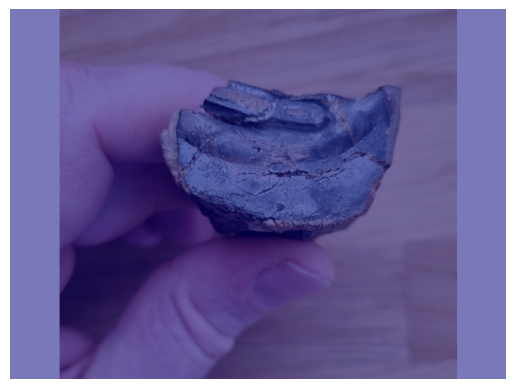

In [68]:
# Running agents
image_path = "Dataset/images/0002.jpg"

# Load the image
image = Image.open(image_path).convert("RGB")

# Chain of messages
msg1 = VisionAgent.send(image)
#msg2 = ExplainAgent.send(msg1)
msg2 = explain_agent({"image": image})
msg3 = ReasoningAgent.send(msg2)

print("FINAL EXPLANATION:")
print(msg2.keys())
print(msg3["explanation"])

#plt.imshow(image)
#plt.axis("off")
#plt.show()
show_gradcam(msg2["image"], msg3["gradcam"])

